[]

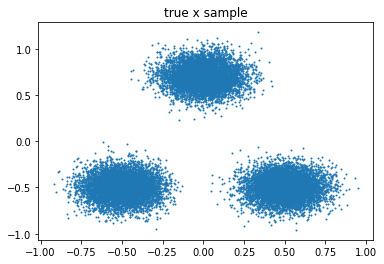

In [13]:
import numpy as np
import torch.nn as nn
import torch.nn.init
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


class CustomDataSet(torch.utils.data.Dataset):

    def __init__(self, n_data):

        self.n_data = n_data
        _data = np.random.randn(n_data, 2)
        mu = [[0.5, -0.5], [0, np.sqrt(0.5)], [-0.5, -0.5]]
        sig = [[0.12, 0.12], [0.12, 0.12], [0.12, 0.12]]
        for i in range(n_data):
            _data[i][0] = sig[i % 3][0] * _data[i][0] + mu[i % 3][0]
            _data[i][1] = sig[i % 3][1] * _data[i][1] + mu[i % 3][1]

        self.data = torch.from_numpy(_data).float()

    def __len__(self):
        return self.n_data

    def __getitem__(self, idx):
        return self.data[idx]


class Discriminator(nn.Module):

    def __init__(self):
        super(Discriminator, self).__init__()
        self.layer = torch.nn.Sequential(
            torch.nn.Linear(in_features=2, out_features=16, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=16, out_features=16, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=16, out_features=16, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=16, out_features=1, bias=True),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        return self.layer(x)


class Generator(nn.Module):

    def __init__(self):
        super(Generator, self).__init__()
        self.layer = torch.nn.Sequential(
            torch.nn.Linear(in_features=4, out_features=16, bias=True),
            torch.nn.LeakyReLU(negative_slope=0.1),
            torch.nn.Linear(in_features=16, out_features=16, bias=True),
            torch.nn.LeakyReLU(negative_slope=0.1),
            torch.nn.Linear(in_features=16, out_features=16, bias=True),
            torch.nn.LeakyReLU(negative_slope=0.1),
            torch.nn.Linear(in_features=16, out_features=2, bias=True),
        )

    def forward(self, x):
        return self.layer(x)


discriminator = Discriminator()
generator = Generator()
d_optimizer = torch.optim.SGD(discriminator.parameters(), lr=0.01)
g_optimizer = torch.optim.SGD(generator.parameters(), lr=0.01)
dataset = CustomDataSet(20000)
batch_size = 16
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
sample_data = dataset.data.numpy()
plt.title('true x sample')
plt.scatter(sample_data[:, 0], sample_data[:, 1], s=1)
plt.plot()

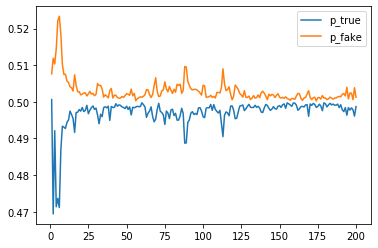

In [14]:
d_true_data_likelihood = []
d_fake_data_likelihood = []
num_epochs = 200
for epoch in range(num_epochs):
    d_true_lh = 0.0
    d_fake_lh = 0.0
    d_loss_avg = 0.0
    g_loss_avg = 0.0
    for batch_index, mini_batch_data in enumerate(loader):
        d_optimizer.zero_grad()
        p_real = discriminator(mini_batch_data)
        p_fake = discriminator(generator(torch.randn(batch_size, 4)))
        d_true_data_loss = -torch.log(p_real).mean()
        d_fake_data_loss = -torch.log(1.0 - p_fake).mean()
        d_loss = (d_true_data_loss + d_fake_data_loss)
        d_loss.backward()
        d_optimizer.step()
        d_true_lh += p_real.mean().item()
        d_fake_lh += p_fake.mean().item()
        g_optimizer.zero_grad()
        p_fake = discriminator(generator(torch.randn(batch_size, 4)))
        g_loss = -torch.log(p_fake).mean()
        g_loss.backward()
        g_optimizer.step()
        d_loss_avg += d_loss.item()
        g_loss_avg += g_loss.item()
    d_true_data_likelihood.append(d_true_lh/len(loader))
    d_fake_data_likelihood.append(d_fake_lh/len(loader))
plt.plot(np.arange(1, len(d_fake_data_likelihood) + 1), d_fake_data_likelihood, label='p_true')
plt.plot(np.arange(1, len(d_true_data_likelihood) + 1), d_true_data_likelihood, label='p_fake')
plt.legend()
plt.show()

[]

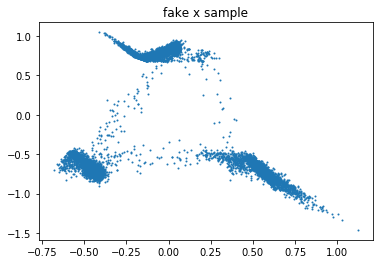

In [15]:
generator_data = generator(torch.randn(10000, 4))
generator_data = generator_data.data.numpy()
plt.title('fake x sample')
plt.scatter(generator_data[:, 0], generator_data[:, 1], s=1)
plt.plot()

[]

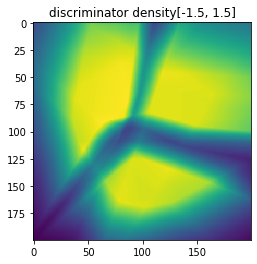

In [36]:
points2D = np.zeros((40000, 2), dtype=np.float)
for i in range(200):
  for j in range(200):
    points2D[i * 200 + j][0] = -1.5 + (3.0/200) * j
    points2D[i * 200 + j][1] = -1.5 + (3.0/200) * i



points2D = torch.from_numpy(points2D).float()
result = discriminator(points2D).data.numpy()
img = np.zeros((200, 200), dtype=np.float)
for i in range(200):
  for j in range(200):
    img[i][j] = result[i*200 + j][0]

plt.title('discriminator density[-1.5, 1.5]')
plt.imshow(img)
plt.plot()